In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import math
import scipy

# Metropolis-Hastings (M-H) algorithm 
MH is a MCMC method for effectively sampling variable $\theta$ from a target distribution. Here
1. target distribution: gamma distribution
$\pi(\theta) = \text{Ga}(\alpha, \beta) = \text{Ga}(3, 1)$ ($k = 3, \theta = 1/1 = 1$). 
2. proposal distribution: exponential distribution $f(\theta) ={Exp}(\lambda)$.
3. independence chains version of M-H, where the transition kernel does not depend on previous state, i.e. $q(\theta, \phi) = f(\phi)$. Then the acceptance ratio is
$$
\alpha(\theta, \phi) = 
\min
\left\{
1, 
\frac{\pi(\phi )/ f(\phi)}{\pi(\theta) / f(\theta)}
\right\}
$$
## Notes for myself
**M-H algorithm**: 

...

Put $\theta^{(j)} = \phi$ with probability $\alpha(\theta_{j-1}, \phi)$, <span style='color:red'>else put $\theta_{j-1}$. </span>

**When using MH sampler in a Bayesian inference problem**:

the target distribution is the posterior $\pi(\theta|x)$. since we only care about the ratio, unnormalized posterior, i.e. joint distribution can be used when computing the acceptance ratio
$$
\pi(\theta|x) \propto \pi(\theta, x) = \pi(x|\theta)\pi(\theta)
$$

**gamma function**: 

1. $\Gamma(\alpha) = (\alpha - 1)!$
2. `math.gamma(x)`

**np.random.exponential**: 

`np.random.exponential(x) -> scalar`, `np.random.exponential(x, size=1) -> array`.


TODO: exact value for the optimal $\lambda$.

In [2]:
class MetropolisHastingsSampler:
    '''M-H sampler for sampling from a target Gamma distribution using a exponential proposal distribution. '''
    def __init__(self, 
                 alpha=3,   
                 beta=1, 
                ): 
        '''
        target distribution: Gamma(`alpha`, `beta`) 
        Attrs: 
        ----
        alpha, beta: float 
            target distribution parameters
        pdf_scaling: float
            the 'norm' term when computing pdf for Gamma distribution
        lam: float 
            proposal distribution parameter
        average_acceptance_ratio: float 
            average accceptance ratio for sampling with `lam`. 
        '''
        if alpha <= 0: 
            raise ValueError('`alpha` should be positive float.')
        if beta <= 0:
            raise ValueError('`beta` should be positive float.')
        
        self.alpha = alpha 
        self.beta = beta
        
        # default lam for 
        self.lam = 0.32
        self.average_acceptance_ratio = None
    
    def initial_point(self, lam):
        '''return initial point for sampling: sample from the exponential distribution.'''
        return self.generate(lam)
    
    def density_gamma(self, x): 
        '''probabilistic density of the target Gamma distribution at given `x`'''
        return np.power(x, self.alpha-1)*np.exp(-x*self.beta) *np.power(self.beta, self.alpha)/(math.gamma(self.alpha))

    def density_exp(self, lam: float, x):
        '''probabilistic density of the proposal Exponential distribution at given `x`'''
        return lam*np.exp(-lam*x)
    
    def generate(self, lam: float): 
        '''generate a proposal value from the proposal exponential distribution. 
        NOTE that scale = 1/lam'''
        return np.random.exponential(scale=1/lam)
      
    def acceptance_ratio(self, lam, x_proposal, x_previous):
        '''compute the density ratio.'''
        a = self.density_gamma(x_proposal) / self.density_exp(lam, x_proposal)
        b = self.density_gamma(x_previous ) / self.density_exp(lam, x_previous)
        return min(a / b, 1)
    
    def tune_lam(self, start: float=0, stop: float=1, step: float=0.1):
        '''find the optimal lam that maximizes the acceptance ratio by grid searching (start, stop] by `step`; the optimal lam and corresponding average acceptance ratio 
        is save in `self.lam` and `self.average_acceptance_ratio`. 
        Returns: 
        ----
        lams: np.array 
            lam values that have been searched. 
        ars: np.array
            corresponding acceptance ratio. '''
        print(f'Start searching for the optimal value of `lam` between ({start}, {stop}] with step (precision) {step}')
        lams = np.arange(start+step, stop+step, step) # [start+step, stop]
        ars = list() 
        
        opt_lam = start
        opt_ar = 0.0
        for lam in lams: 
            X, acceptance_ratios = self.sample(lam=lam)
            ar_mean = acceptance_ratios.mean()
            ars.append(ar_mean)
            print(f'lam = {lam: .3f}, acceptance ratio = {ar_mean: .3f}')
            
            if ar_mean > opt_ar: 
                opt_ar = ar_mean 
                opt_lam = lam
        
        print(f'Searching finished. The optimal lam = {opt_lam: .3f}, acceptance ratio = {opt_ar: .3f}')
        self.lam = opt_lam
        self.average_acceptance_ratio = opt_ar
        return lams, np.asarray(ars)
        
    def sample(self, num_iterations=int(1e5), lam=None, initial_point=None): 
        '''run M-H algorithm for `num_iterations`. 
        Returns: 
        ----
        X: array
            samples. NOTE that len(X) <= `num_iterations` since proposal points at some iterations would be rejected. 
        acceptance_ratios: array
            acceptance ratios for per iteration. NOTE that len(acceptance_ratios) == `num_iterations`.
        '''
        if lam is None:
            lam = self.lam
        if initial_point is None: 
            initial_point = self.initial_point(lam)
            
        X = list()
        acceptance_ratios = list()
        x_previous = initial_point
        for idx in range(num_iterations):
            x_proposal = self.generate(lam=lam)
            ar = self.acceptance_ratio(lam, x_proposal, x_previous)
            acceptance_ratios.append(ar)
            
            if np.random.random() <= ar:
                x_previous = x_proposal
                
            X.append(x_previous) # NOTE put theta_j as proposal with prob acceptance_ratio, else put theta_j as theta_{j-1}!
                
        return np.asarray(X), np.asarray(acceptance_ratios)

## a) Find the optimal proposal distribution aka find the $\lambda$ that maximizes the acceptance ratio. Show a plot for an appropriate interval of $\lambda$. Print out the value of $\lambda_{\text{opt}}$.
Determine the values with precision $\pm 0.05$.
### Receipts
1. choose initially $\lambda_i \in [0.1, 1]$ with a suitable step of $0.1$. 
2. perform $10^5$ iterations of evaluations to determine $\lambda = \lambda_{\text{opt}}$. </br>
<span style='color: red'>(we are assuming there is only a single mode)</span>
3. narrow down the interval and steps for $\lambda_{\text{opt}}$ until we can determine the value $\lambda = \lambda_{\text{opt}}$ with precision $0.05$. 

The searching steps we use exactly reflects precision: with $\text{step} = s$ and the true optimal value $\lambda_{\text{opt}}$, we will at least find a sub-optimal value between $[\lambda_{\text{opt}} - s, \lambda_{\text{opt}}+s]$. 

### Results 
By performing the first round of searching we found $\lambda_{\text{opt}} = 0.3$, which indicates that the true optimal value should locate between $(0.2, 0.4)$. In the second searching round, we narrowed down the interval to $(0.2, 0.4]$ as well as the step to $0.025$. We found $ \lambda_{\text{opt}} = 0.35$. Now the true optimal value should be somewhere between $0.325$ and $0.375$, i.e. $0.35 \pm 0.025$. 

For each grid searching process, a **plot** with $\lambda$ on the horizontal axis and corresponding average acceptance ratio on the vertical axis is shown.The black vertical dotted line and red point indicate the location of optimal value $\lambda_{\text{opt}}$ that we found, and the gray vertical dotted lines show the interval $(\lambda_{\text{opt}} - \text{step}, \lambda_{\text{opt}} + \text{step})$.

**Therefore, the optimal value for $\lambda$ is $0.35$.**

In [3]:
mh_sampler = MetropolisHastingsSampler()

In [4]:
def plot_lambda_acceptance_ratio(lams, ars, precision): 
    plt.figure(figsize=(8, 4))
    plt.plot(lams, ars)
    plt.xlabel('lambda')
    plt.ylabel('Average acceptance ratio')
    opt_lam = lams[np.argmax(ars)]
    plt.scatter(x=opt_lam, y=max(ars), c='r')
    plt.vlines(opt_lam, min(ars), max(ars), linestyles ="dotted", colors ="k")

    plt.vlines(opt_lam-precision, min(ars), max(ars), linestyles ="dotted", colors ="darkgray")
    plt.vlines(opt_lam+precision, min(ars), max(ars), linestyles ="dotted", colors ="darkgray")
    plt.title(f'optimal value between ({min(lams)}, {max(lams)}], with precision = {precision}')
    plt.show()

Start searching for the optimal value of `lam` between (0, 1] with step (precision) 0.1
lam =  0.100, acceptance ratio =  0.370
lam =  0.200, acceptance ratio =  0.562
lam =  0.300, acceptance ratio =  0.635
lam =  0.400, acceptance ratio =  0.624
lam =  0.500, acceptance ratio =  0.563
lam =  0.600, acceptance ratio =  0.484
lam =  0.700, acceptance ratio =  0.405
lam =  0.800, acceptance ratio =  0.344
lam =  0.900, acceptance ratio =  0.291
lam =  1.000, acceptance ratio =  0.250
Searching finished. The optimal lam =  0.300, acceptance ratio =  0.635


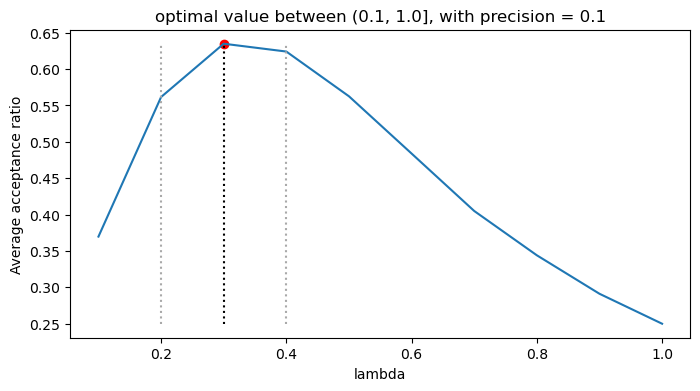

Start searching for the optimal value of `lam` between (0.2, 0.4] with step (precision) 0.025
lam =  0.225, acceptance ratio =  0.591
lam =  0.250, acceptance ratio =  0.610
lam =  0.275, acceptance ratio =  0.625
lam =  0.300, acceptance ratio =  0.634
lam =  0.325, acceptance ratio =  0.636
lam =  0.350, acceptance ratio =  0.640
lam =  0.375, acceptance ratio =  0.633
lam =  0.400, acceptance ratio =  0.623
lam =  0.425, acceptance ratio =  0.613
Searching finished. The optimal lam =  0.350, acceptance ratio =  0.640


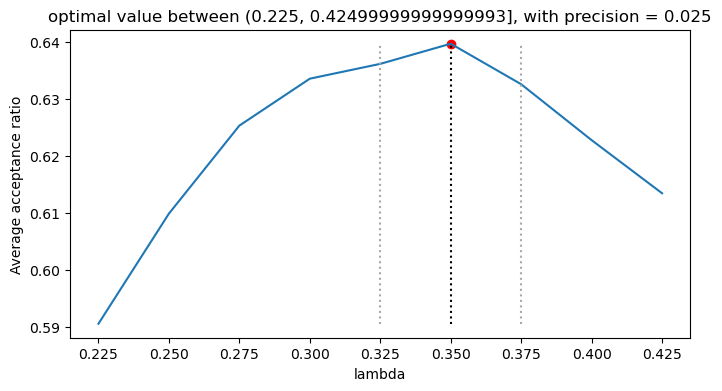

In [5]:
lams, ars = mh_sampler.tune_lam()
plot_lambda_acceptance_ratio(lams, ars, precision=0.1)
lams, ars = mh_sampler.tune_lam(start=0.2, stop=0.4, step=0.025)
plot_lambda_acceptance_ratio(lams, ars, precision=0.025)

## b) Use the optimal proposal distribution to simulate $\text{Ga}(3, 1)$. Plot the resulting distribution with corresponding functional for the gamma distribution. 
- Simulate for $10^6$ samples. 
- histogram for the resulting distribution. 
- line plot for the gamma distribution. 


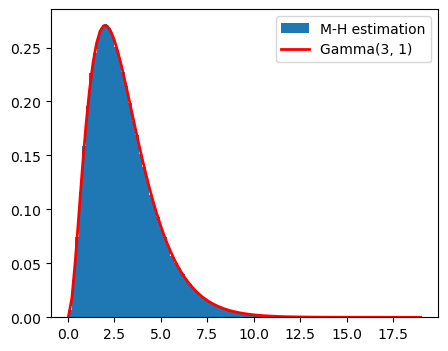

In [6]:
plt.figure(figsize=(5,4))
samples, _ = mh_sampler.sample(num_iterations=int(1e6))
count, bins,_ = plt.hist(samples, bins=100, density=True, label='M-H estimation')
        
y = mh_sampler.density_gamma(bins)
plt.plot(bins, y, linewidth=2, color='r', label='Gamma(3, 1)')
plt.legend()
plt.show()

## c) Compute and print the numerial values for mean and variance for the resulting distribution. 

In [7]:
mean = samples.mean()
var = samples.var()
print(f'mean = {mean: .4f}, variance = {var: .4f}')

mean =  2.9975, variance =  2.9938


Since we know the target distribution is $\text{Ga(3, 1)}$, we can write down the exact mean and variance for verification: 

In [8]:
print(f'[for verification] exact mean = {3/1: .4f}, exact variance = {3/(1**2): .4f}')

[for verification] exact mean =  3.0000, exact variance =  3.0000


## d) Which of the two methods, the Gibbs sampler or Metropolis-Hastings, requires less information and so is more generally applicable?

By comparing these two methods in term of requiring information,

1. Gibbs sampler: the **full conditional distribution for each parameters**.
2. Metropolis-Hasting: the **unnormalized target distribution**, and a **proposal distribution** which can be *any* distribution.</br>
    - of course the selection of the proposal distribution will affect acceptance ratio, and then the efficiency of algorithm.
    - unnormalized target distribution means that we can directly use the joint distribution of data and parameters without normalizing it with the marginal likelihood in a Bayesian inference problem. This a not difficult. 

It turns out that the M-H sampler requires less information and so is more generally applicable. 
